In [1]:
!pip install -q torchgeometry
!pip install -q timm==0.6.12

In [2]:
from torchgeometry.losses import one_hot
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import time
import imageio
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Resize, PILToTensor, ToPILImage, Compose, InterpolationMode
from collections import OrderedDict
from torchvision import transforms
from tqdm import tqdm
import wandb

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
num_classes = 3

# Number of epochs
epochs = 80

# Hyperparameters for training 
learning_rate = 5e-06
batch_size = 8
display_step = 50

pretrained_encoder_path = '/kaggle/input/polyp_pvt2_b2/pytorch/default/2/pvt_v2_b2.pth'
pretrained_path = '/kaggle/input/polyp_pvt2_b2/pytorch/default/2/emcad_model.pth'


# Utils

In [5]:
def powerset(seq):
    """
    Returns all the subsets of this set. This is a generator.
    """
    if len(seq) <= 1:
        yield seq
        yield []
    else:
        for item in powerset(seq[1:]):
            yield [seq[0]]+item
            yield item

def clip_gradient(optimizer, grad_clip):
    """
    For calibrating misalignment gradient via cliping gradient technique
    :param optimizer:
    :param grad_clip:
    :return:
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

def adjust_lr(optimizer, init_lr, epoch, decay_rate=0.1, decay_epoch=30):
    decay = decay_rate ** (epoch // decay_epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay


# Model

## Decoder

In [6]:
import torch
import torch.nn as nn
from functools import partial

import math
from timm.models.layers import trunc_normal_tf_
from timm.models.helpers import named_apply


def gcd(a, b):
    while b:
        a, b = b, a % b
    return a

# Other types of layers can go here (e.g., nn.Linear, etc.)
def _init_weights(module, name, scheme=''):
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Conv3d):
        if scheme == 'normal':
            nn.init.normal_(module.weight, std=.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif scheme == 'trunc_normal':
            trunc_normal_tf_(module.weight, std=.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif scheme == 'xavier_normal':
            nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif scheme == 'kaiming_normal':
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        else:
            # efficientnet like
            fan_out = module.kernel_size[0] * module.kernel_size[1] * module.out_channels
            fan_out //= module.groups
            nn.init.normal_(module.weight, 0, math.sqrt(2.0 / fan_out))
            if module.bias is not None:
                nn.init.zeros_(module.bias)
    elif isinstance(module, nn.BatchNorm2d) or isinstance(module, nn.BatchNorm3d):
        nn.init.constant_(module.weight, 1)
        nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.LayerNorm):
        nn.init.constant_(module.weight, 1)
        nn.init.constant_(module.bias, 0)

def act_layer(act, inplace=False, neg_slope=0.2, n_prelu=1):
    # activation layer
    act = act.lower()
    if act == 'relu':
        layer = nn.ReLU(inplace)
    elif act == 'relu6':
        layer = nn.ReLU6(inplace)
    elif act == 'leakyrelu':
        layer = nn.LeakyReLU(neg_slope, inplace)
    elif act == 'prelu':
        layer = nn.PReLU(num_parameters=n_prelu, init=neg_slope)
    elif act == 'gelu':
        layer = nn.GELU()
    elif act == 'hswish':
        layer = nn.Hardswish(inplace)
    else:
        raise NotImplementedError('activation layer [%s] is not found' % act)
    return layer

def channel_shuffle(x, groups):
    batchsize, num_channels, height, width = x.data.size()
    channels_per_group = num_channels // groups    
    # reshape
    x = x.view(batchsize, groups, 
               channels_per_group, height, width)
    x = torch.transpose(x, 1, 2).contiguous()
    # flatten
    x = x.view(batchsize, -1, height, width)
    return x

#   Multi-scale depth-wise convolution (MSDC)
class MSDC(nn.Module):
    def __init__(self, in_channels, kernel_sizes, stride, activation='relu6', dw_parallel=True):
        super(MSDC, self).__init__()

        self.in_channels = in_channels
        self.kernel_sizes = kernel_sizes
        self.activation = activation
        self.dw_parallel = dw_parallel

        self.dwconvs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(self.in_channels, self.in_channels, kernel_size, stride, kernel_size // 2, groups=self.in_channels, bias=False),
                nn.BatchNorm2d(self.in_channels),
                act_layer(self.activation, inplace=True)
            )
            for kernel_size in self.kernel_sizes
        ])

        self.init_weights('normal')
    
    def init_weights(self, scheme=''):
        named_apply(partial(_init_weights, scheme=scheme), self)

    def forward(self, x):
        # Apply the convolution layers in a loop
        outputs = []
        for dwconv in self.dwconvs:
            dw_out = dwconv(x)
            outputs.append(dw_out)
            if self.dw_parallel == False:
                x = x+dw_out
        # You can return outputs based on what you intend to do with them
        return outputs

class MSCB(nn.Module):
    """
    Multi-scale convolution block (MSCB) 
    """
    def __init__(self, in_channels, out_channels, stride, kernel_sizes=[1,3,5], expansion_factor=2, dw_parallel=True, add=True, activation='relu6'):
        super(MSCB, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.kernel_sizes = kernel_sizes
        self.expansion_factor = expansion_factor
        self.dw_parallel = dw_parallel
        self.add = add
        self.activation = activation
        self.n_scales = len(self.kernel_sizes)
        # check stride value
        assert self.stride in [1, 2]
        # Skip connection if stride is 1
        self.use_skip_connection = True if self.stride == 1 else False

        # expansion factor
        self.ex_channels = int(self.in_channels * self.expansion_factor)
        self.pconv1 = nn.Sequential(
            # pointwise convolution
            nn.Conv2d(self.in_channels, self.ex_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ex_channels),
            act_layer(self.activation, inplace=True)
        )
        self.msdc = MSDC(self.ex_channels, self.kernel_sizes, self.stride, self.activation, dw_parallel=self.dw_parallel)
        if self.add == True:
            self.combined_channels = self.ex_channels*1
        else:
            self.combined_channels = self.ex_channels*self.n_scales
        self.pconv2 = nn.Sequential(
            # pointwise convolution
            nn.Conv2d(self.combined_channels, self.out_channels, 1, 1, 0, bias=False), 
            nn.BatchNorm2d(self.out_channels),
        )
        if self.use_skip_connection and (self.in_channels != self.out_channels):
            self.conv1x1 = nn.Conv2d(self.in_channels, self.out_channels, 1, 1, 0, bias=False)
        self.init_weights('normal')
    
    def init_weights(self, scheme=''):
        named_apply(partial(_init_weights, scheme=scheme), self)

    def forward(self, x):
        pout1 = self.pconv1(x)
        msdc_outs = self.msdc(pout1)
        if self.add == True:
            dout = 0
            for dwout in msdc_outs:
                dout = dout + dwout
        else:
            dout = torch.cat(msdc_outs, dim=1)
        dout = channel_shuffle(dout, gcd(self.combined_channels,self.out_channels))
        out = self.pconv2(dout)
        if self.use_skip_connection:
            if self.in_channels != self.out_channels:
                x = self.conv1x1(x)
            return x + out
        else:
            return out
        
#   Multi-scale convolution block (MSCB)
def MSCBLayer(in_channels, out_channels, n=1, stride=1, kernel_sizes=[1,3,5], expansion_factor=2, dw_parallel=True, add=True, activation='relu6'):
        """
        create a series of multi-scale convolution blocks.
        """
        convs = []
        mscb = MSCB(in_channels, out_channels, stride, kernel_sizes=kernel_sizes, expansion_factor=expansion_factor, dw_parallel=dw_parallel, add=add, activation=activation)
        convs.append(mscb)
        if n > 1:
            for i in range(1, n):
                mscb = MSCB(out_channels, out_channels, 1, kernel_sizes=kernel_sizes, expansion_factor=expansion_factor, dw_parallel=dw_parallel, add=add, activation=activation)
                convs.append(mscb)
        conv = nn.Sequential(*convs)
        return conv

#   Efficient up-convolution block (EUCB)
class EUCB(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, activation='relu'):
        super(EUCB,self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.up_dwc = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(self.in_channels, self.in_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, groups=self.in_channels, bias=False),
	        nn.BatchNorm2d(self.in_channels),
            act_layer(activation, inplace=True)
        )
        self.pwc = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=1, padding=0, bias=True)
        ) 
        self.init_weights('normal')
    
    def init_weights(self, scheme=''):
        named_apply(partial(_init_weights, scheme=scheme), self)

    def forward(self, x):
        x = self.up_dwc(x)
        x = channel_shuffle(x, self.in_channels)
        x = self.pwc(x)
        return x

#   Large-kernel grouped attention gate (LGAG)
class LGAG(nn.Module):
    def __init__(self, F_g, F_l, F_int, kernel_size=3, groups=1, activation='relu'):
        super(LGAG,self).__init__()

        if kernel_size == 1:
            groups = 1
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=kernel_size, stride=1, padding=kernel_size//2, groups=groups, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=kernel_size, stride=1, padding=kernel_size//2, groups=groups, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.activation = act_layer(activation, inplace=True)

        self.init_weights('normal')
    
    def init_weights(self, scheme=''):
        named_apply(partial(_init_weights, scheme=scheme), self)
                
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.activation(g1 + x1)
        psi = self.psi(psi)

        return x*psi
    
#   Channel attention block (CAB)
class CAB(nn.Module):
    def __init__(self, in_channels, out_channels=None, ratio=16, activation='relu'):
        super(CAB, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        if self.in_channels < ratio:
            ratio = self.in_channels
        self.reduced_channels = self.in_channels // ratio
        if self.out_channels == None:
            self.out_channels = in_channels

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.activation = act_layer(activation, inplace=True)
        self.fc1 = nn.Conv2d(self.in_channels, self.reduced_channels, 1, bias=False)
        self.fc2 = nn.Conv2d(self.reduced_channels, self.out_channels, 1, bias=False)
        
        self.sigmoid = nn.Sigmoid()

        self.init_weights('normal')
    
    def init_weights(self, scheme=''):
        named_apply(partial(_init_weights, scheme=scheme), self)

    def forward(self, x):
        avg_pool_out = self.avg_pool(x) 
        avg_out = self.fc2(self.activation(self.fc1(avg_pool_out)))

        max_pool_out= self.max_pool(x) 
        max_out = self.fc2(self.activation(self.fc1(max_pool_out)))

        out = avg_out + max_out
        return self.sigmoid(out) 
    
#   Spatial attention block (SAB)
class SAB(nn.Module):
    def __init__(self, kernel_size=7):
        super(SAB, self).__init__()

        assert kernel_size in (3, 7, 11), 'kernel must be 3 or 7 or 11'
        padding = kernel_size//2

        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
           
        self.sigmoid = nn.Sigmoid()

        self.init_weights('normal')
    
    def init_weights(self, scheme=''):
        named_apply(partial(_init_weights, scheme=scheme), self)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

#   Efficient multi-scale convolutional attention decoding (EMCAD)
class EMCAD(nn.Module):
    def __init__(self, channels=[512,320,128,64], kernel_sizes=[1,3,5], expansion_factor=6, dw_parallel=True, add=True, lgag_ks=3, activation='relu6'):
        super(EMCAD,self).__init__()
        eucb_ks = 3 # kernel size for eucb
        self.mscb4 = MSCBLayer(channels[0], channels[0], n=1, stride=1, kernel_sizes=kernel_sizes, expansion_factor=expansion_factor, dw_parallel=dw_parallel, add=add, activation=activation)
	
        self.eucb3 = EUCB(in_channels=channels[0], out_channels=channels[1], kernel_size=eucb_ks, stride=eucb_ks//2)
        self.lgag3 = LGAG(F_g=channels[1], F_l=channels[1], F_int=channels[1]//2, kernel_size=lgag_ks, groups=channels[1]//2)
        self.mscb3 = MSCBLayer(channels[1], channels[1], n=1, stride=1, kernel_sizes=kernel_sizes, expansion_factor=expansion_factor, dw_parallel=dw_parallel, add=add, activation=activation)

        self.eucb2 = EUCB(in_channels=channels[1], out_channels=channels[2], kernel_size=eucb_ks, stride=eucb_ks//2)
        self.lgag2 = LGAG(F_g=channels[2], F_l=channels[2], F_int=channels[2]//2, kernel_size=lgag_ks, groups=channels[2]//2)
        self.mscb2 = MSCBLayer(channels[2], channels[2], n=1, stride=1, kernel_sizes=kernel_sizes, expansion_factor=expansion_factor, dw_parallel=dw_parallel, add=add, activation=activation)
        
        self.eucb1 = EUCB(in_channels=channels[2], out_channels=channels[3], kernel_size=eucb_ks, stride=eucb_ks//2)
        self.lgag1 = LGAG(F_g=channels[3], F_l=channels[3], F_int=int(channels[3]/2), kernel_size=lgag_ks, groups=int(channels[3]/2))
        self.mscb1 = MSCBLayer(channels[3], channels[3], n=1, stride=1, kernel_sizes=kernel_sizes, expansion_factor=expansion_factor, dw_parallel=dw_parallel, add=add, activation=activation)
        
        self.cab4 = CAB(channels[0])
        self.cab3 = CAB(channels[1])
        self.cab2 = CAB(channels[2])
        self.cab1 = CAB(channels[3])
        
        self.sab = SAB()
       
      
    def forward(self, x, skips):
            
        # MSCAM4
        d4 = self.cab4(x)*x
        d4 = self.sab(d4)*d4 
        d4 = self.mscb4(d4)
        
        # EUCB3
        d3 = self.eucb3(d4)
                
        # LGAG3
        x3 = self.lgag3(g=d3, x=skips[0])
        
        # Additive aggregation 3
        d3 = d3 + x3
        
        # MSCAM3
        d3 = self.cab3(d3)*d3
        d3 = self.sab(d3)*d3  
        d3 = self.mscb3(d3)
        
        # EUCB2
        d2 = self.eucb2(d3)
        
        # LGAG2
        x2 = self.lgag2(g=d2, x=skips[1])
        
        # Additive aggregation 2
        d2 = d2 + x2 
        
        # MSCAM2
        d2 = self.cab2(d2)*d2
        d2 = self.sab(d2)*d2
        d2 = self.mscb2(d2)
        
        # EUCB1
        d1 = self.eucb1(d2)
        
        # LGAG1
        x1 = self.lgag1(g=d1, x=skips[2])
        
        # Additive aggregation 1
        d1 = d1 + x1 
        
        # MSCAM1
        d1 = self.cab1(d1)*d1
        d1 = self.sab(d1)*d1
        d1 = self.mscb1(d1)
        
        return [d4, d3, d2, d1]

## Encoder PVT

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model

import math


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = self.fc1(x)
        x = self.dwconv(x, H, W)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        if self.sr_ratio > 1:
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.norm(x_)
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))

        return x


class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class PyramidVisionTransformerImpr(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dims=[64, 128, 256, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1]):
        super().__init__()
        self.num_classes = num_classes
        self.depths = depths

        # patch_embed
        self.patch_embed1 = OverlapPatchEmbed(img_size=img_size, patch_size=7, stride=4, in_chans=in_chans,
                                              embed_dim=embed_dims[0])
        self.patch_embed2 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 16, patch_size=3, stride=2, in_chans=embed_dims[2],
                                              embed_dim=embed_dims[3])

        # transformer encoder
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
        cur = 0
        self.block1 = nn.ModuleList([Block(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=mlp_ratios[0], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])
            for i in range(depths[0])])
        self.norm1 = norm_layer(embed_dims[0])

        cur += depths[0]
        self.block2 = nn.ModuleList([Block(
            dim=embed_dims[1], num_heads=num_heads[1], mlp_ratio=mlp_ratios[1], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[1])
            for i in range(depths[1])])
        self.norm2 = norm_layer(embed_dims[1])

        cur += depths[1]
        self.block3 = nn.ModuleList([Block(
            dim=embed_dims[2], num_heads=num_heads[2], mlp_ratio=mlp_ratios[2], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[2])
            for i in range(depths[2])])
        self.norm3 = norm_layer(embed_dims[2])

        cur += depths[2]
        self.block4 = nn.ModuleList([Block(
            dim=embed_dims[3], num_heads=num_heads[3], mlp_ratio=mlp_ratios[3], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[3])
            for i in range(depths[3])])
        self.norm4 = norm_layer(embed_dims[3])

        # classification head
        # self.head = nn.Linear(embed_dims[3], num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def init_weights(self, pretrained=None):
        if isinstance(pretrained, str):
            logger = 1
            #load_checkpoint(self, pretrained, map_location='cpu', strict=False, logger=logger)

    def reset_drop_path(self, drop_path_rate):
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(self.depths))]
        cur = 0
        for i in range(self.depths[0]):
            self.block1[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[0]
        for i in range(self.depths[1]):
            self.block2[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[1]
        for i in range(self.depths[2]):
            self.block3[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[2]
        for i in range(self.depths[3]):
            self.block4[i].drop_path.drop_prob = dpr[cur + i]

    def freeze_patch_emb(self):
        self.patch_embed1.requires_grad = False

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed1', 'pos_embed2', 'pos_embed3', 'pos_embed4', 'cls_token'}  # has pos_embed may be better

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    # def _get_pos_embed(self, pos_embed, patch_embed, H, W):
    #     if H * W == self.patch_embed1.num_patches:
    #         return pos_embed
    #     else:
    #         return F.interpolate(
    #             pos_embed.reshape(1, patch_embed.H, patch_embed.W, -1).permute(0, 3, 1, 2),
    #             size=(H, W), mode="bilinear").reshape(1, -1, H * W).permute(0, 2, 1)

    def forward_features(self, x):
        B = x.shape[0]
        outs = []
        
        # stage 1
        x, H, W = self.patch_embed1(x)
        for i, blk in enumerate(self.block1):
            x = blk(x, H, W)
        x = self.norm1(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 2
        x, H, W = self.patch_embed2(x)
        for i, blk in enumerate(self.block2):
            x = blk(x, H, W)
        x = self.norm2(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 3
        x, H, W = self.patch_embed3(x)
        for i, blk in enumerate(self.block3):
            x = blk(x, H, W)
        x = self.norm3(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 4
        x, H, W = self.patch_embed4(x)
        for i, blk in enumerate(self.block4):
            x = blk(x, H, W)
        x = self.norm4(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        return outs

        # return x.mean(dim=1)

    def forward(self, x):
        x = self.forward_features(x)
        # x = self.head(x)

        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x


def _conv_filter(state_dict, patch_size=16):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v

    return out_dict


@register_model
class pvt_v2_b0(PyramidVisionTransformerImpr):
    def __init__(self, **kwargs):
        super(pvt_v2_b0, self).__init__(
            patch_size=4, embed_dims=[32, 64, 160, 256], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)



@register_model
class pvt_v2_b1(PyramidVisionTransformerImpr):
    def __init__(self, **kwargs):
        super(pvt_v2_b1, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)

@register_model
class pvt_v2_b2(PyramidVisionTransformerImpr):
    def __init__(self, **kwargs):
        super(pvt_v2_b2, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)

@register_model
class pvt_v2_b3(PyramidVisionTransformerImpr):
    def __init__(self, **kwargs):
        super(pvt_v2_b3, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 18, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)

@register_model
class pvt_v2_b4(PyramidVisionTransformerImpr):
    def __init__(self, **kwargs):
        super(pvt_v2_b4, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 8, 27, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


@register_model
class pvt_v2_b5(PyramidVisionTransformerImpr):
    def __init__(self, **kwargs):
        super(pvt_v2_b5, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 6, 40, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)

## Encoder ResNet

In [8]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 10 09:57:49 2019

@author: Fsl
"""

import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
#import torchsummary

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * Bottleneck.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * Bottleneck.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000,deep_base=False,stem_width=32):
        self.inplanes = stem_width*2 if deep_base else 64
        
        super(ResNet, self).__init__()
        if deep_base:
            self.conv1= nn.Sequential(
                nn.Conv2d(3, stem_width, kernel_size=3, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(stem_width),
                nn.ReLU(inplace=True),
                nn.Conv2d(stem_width, stem_width, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(stem_width),
                nn.ReLU(inplace=True),
                nn.Conv2d(stem_width, stem_width*2, kernel_size=3, stride=1, padding=1, bias=False),
            )
        else:
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                                   bias=False)
        
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        features = []

        x = self.layer1(x)
        features.append(x)
        x = self.layer2(x)
        features.append(x)
        x = self.layer3(x)
        features.append(x)
        x = self.layer4(x)
        features.append(x)

        # x = self.avgpool(x)
        # x = x.view(x.size(0), -1)
        # x = self.fc(x)

        return features


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    model_dict = model.state_dict()


    if pretrained:
        print('Using pretrained weight!')
        pretrained_dict=model_zoo.load_url(model_urls['resnet34'])# Modify 'model_dir' according to your own path
        print('Petrain Model Have been loaded!')
        # pretrained_dict =  {k: v for k, v in pretrained_dict.items() if k in model_dict}
        # model_dict.update(pretrained_dict)
        model.load_state_dict(pretrained_dict)
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        print('Using pretrained weight!')
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model
# net = resnet34(pretrained=False)
# torchsummary.summary(net, (3, 512, 512))

## Combine Network

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class EMCADNet(nn.Module):
    def __init__(self, num_classes=1, kernel_sizes=[1,3,5], expansion_factor=2, dw_parallel=True, add=True, lgag_ks=3, activation='relu', encoder='pvt_v2_b2', pretrain=True):
        super(EMCADNet, self).__init__()

        # conv block to convert single channel to 3 channels
        self.conv = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=1),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True)
        )
        
        # backbone network initialization with pretrained weight
        if encoder == 'pvt_v2_b0':
            self.backbone = pvt_v2_b0()
            path = './pretrained_pth/pvt/pvt_v2_b0.pth'
            channels=[256, 160, 64, 32]
        elif encoder == 'pvt_v2_b1':
            self.backbone = pvt_v2_b1()
            path = './pretrained_pth/pvt/pvt_v2_b1.pth'
            channels=[512, 320, 128, 64]
        elif encoder == 'pvt_v2_b2':
            self.backbone = pvt_v2_b2()
            path = '/kaggle/input/polyp_pvt2_b2/pytorch/default/2/pvt_v2_b2.pth'
            channels=[512, 320, 128, 64]
        elif encoder == 'pvt_v2_b3':
            self.backbone = pvt_v2_b3()
            path = './pretrained_pth/pvt/pvt_v2_b3.pth'
            channels=[512, 320, 128, 64]
        elif encoder == 'pvt_v2_b4':
            self.backbone = pvt_v2_b4()
            path = './pretrained_pth/pvt/pvt_v2_b4.pth'
            channels=[512, 320, 128, 64]
        elif encoder == 'pvt_v2_b5':
            self.backbone = pvt_v2_b5() 
            path = './pretrained_pth/pvt/pvt_v2_b5.pth'
            channels=[512, 320, 128, 64]
        elif encoder == 'resnet18':
            self.backbone = resnet18(pretrained=pretrain)
            channels=[512, 256, 128, 64]
        elif encoder == 'resnet34':
            self.backbone = resnet34(pretrained=pretrain)
            channels=[512, 256, 128, 64]
        elif encoder == 'resnet50':
            self.backbone = resnet50(pretrained=pretrain)
            channels=[2048, 1024, 512, 256]
        elif encoder == 'resnet101':
            self.backbone = resnet101(pretrained=pretrain)  
            channels=[2048, 1024, 512, 256]
        elif encoder == 'resnet152':
            self.backbone = resnet152(pretrained=pretrain)  
            channels=[2048, 1024, 512, 256]
        else:
            print('Encoder not implemented! Continuing with default encoder pvt_v2_b2.')
            self.backbone = pvt_v2_b2()  
            path = '/kaggle/input/polyp_pvt2_b2/pytorch/default/2/pvt_v2_b2.pth'
            channels=[512, 320, 128, 64]
            
        if pretrain==True and 'pvt_v2' in encoder:
            save_model = torch.load(path, weights_only = True)
            model_dict = self.backbone.state_dict()
            state_dict = {k: v for k, v in save_model.items() if k in model_dict.keys()}
            model_dict.update(state_dict)
            self.backbone.load_state_dict(model_dict)
            print('loaded pretrained weight successfully')
        
        # print('Model %s created, param count: %d' %
        #              (encoder+' backbone: ', (sum([m.numel() for m in self.backbone.parameters()])/1e6)))
        
        #   decoder initialization
        self.decoder = EMCAD(channels=channels, kernel_sizes=kernel_sizes, expansion_factor=expansion_factor, dw_parallel=dw_parallel, add=add, lgag_ks=lgag_ks, activation=activation)
        
        # print('Model %s created, param count: %d' %
        #              ('EMCAD decoder: ', sum([m.numel() for m in self.decoder.parameters()])/1e6))
             
        self.out_head4 = nn.Conv2d(channels[0], num_classes, 1)
        self.out_head3 = nn.Conv2d(channels[1], num_classes, 1)
        self.out_head2 = nn.Conv2d(channels[2], num_classes, 1)
        self.out_head1 = nn.Conv2d(channels[3], num_classes, 1)
        
    def forward(self, x, mode='test'):
        
        # if grayscale input, convert to 3 channels
        if x.size()[1] == 1:
            x = self.conv(x)
        
        # encoder
        x1, x2, x3, x4 = self.backbone(x)
        #print(x1.shape, x2.shape, x3.shape, x4.shape)

        # decoder
        dec_outs = self.decoder(x4, [x3, x2, x1])
        
        # prediction heads  
        p4 = self.out_head4(dec_outs[0])
        p3 = self.out_head3(dec_outs[1])
        p2 = self.out_head2(dec_outs[2])
        p1 = self.out_head1(dec_outs[3])

        p4 = F.interpolate(p4, scale_factor=32, mode='bilinear')
        p3 = F.interpolate(p3, scale_factor=16, mode='bilinear')
        p2 = F.interpolate(p2, scale_factor=8, mode='bilinear')
        p1 = F.interpolate(p1, scale_factor=4, mode='bilinear')

        if mode == 'test':
            return [p4, p3, p2, p1]
        
        return [p4, p3, p2, p1]

In [10]:
model = EMCADNet(num_classes = 3)
input_tensor = torch.randn(1, 3, 352, 352)

P = model(input_tensor)
print(P[0].size(), P[1].size(), P[2].size(), P[3].size())


loaded pretrained weight successfully
torch.Size([1, 3, 352, 352]) torch.Size([1, 3, 352, 352]) torch.Size([1, 3, 352, 352]) torch.Size([1, 3, 352, 352])


# Dataloader

## Original Loader

In [11]:
transform = transforms.Compose([Resize((512, 512), interpolation=InterpolationMode.BILINEAR),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [12]:
class UNetDataClass(Dataset):
    def __init__(self, images_path, masks_path, transform):
        super(UNetDataClass, self).__init__()
        
        images_list = os.listdir(images_path)
        masks_list = os.listdir(masks_path)
        
        images_list = [images_path + image_name for image_name in images_list]
        masks_list = [masks_path + mask_name for mask_name in masks_list]
        
        self.images_list = images_list
        self.masks_list = masks_list
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.images_list[index]
        mask_path = self.masks_list[index]
        
        # Open image and mask
        data = Image.open(img_path).convert('RGB')
        label = Image.open(mask_path).convert('RGB')
        
        # Normalize
        data = self.transform(data) 
        label = self.transform(label) 
        
        label = torch.where(label>0.65, 1.0, 0.0)
        
        label[2, :, :] = 0.0001
        label = torch.argmax(label, 0).type(torch.int64)
        return data, label
    
    def __len__(self):
        return len(self.images_list)

In [13]:
images_path = "/kaggle/input/bkai-igh-neopolyp/train/train/"
masks_path =  "/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/"

In [14]:
unet_dataset = UNetDataClass(images_path, masks_path, transform)
train_size = 0.9
valid_size = 0.1

4

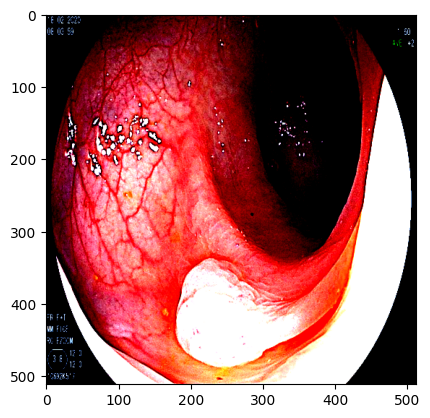

In [15]:
image, label= unet_dataset[0]
plt.imshow(image.permute(1,2,0))
image_1 = image.unsqueeze(0) 
output = model(image_1) 
len(output)
# plt.imshow(output[0].squeeze(0).permute(1,2,0).detach().numpy())

## Data Augmentation

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


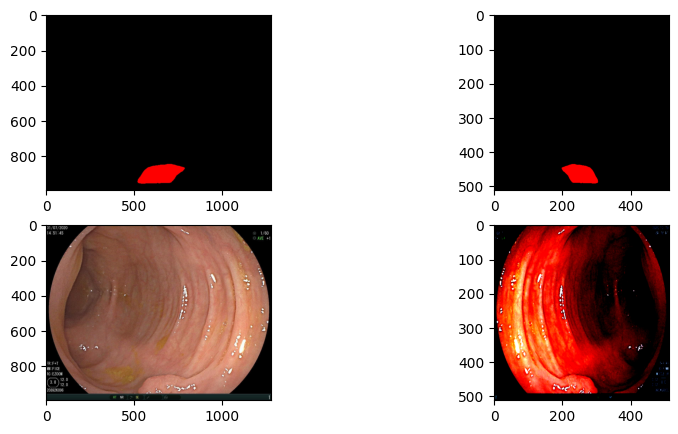

In [16]:
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt

augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),  # Horizontal Flip
    A.RandomRotate90(p=0.5),  # Random 90-degree rotation
    A.ShiftScaleRotate(p=0.45, border_mode=cv2.BORDER_CONSTANT, shift_limit=0.15, scale_limit=0.15),
    A.RandomGamma (gamma_limit=(70, 130), always_apply=False, p=0.2),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),  # Gaussian blur
    A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.15, brightness_coeff=1.5, p=0.09),
    A.CoarseDropout(max_holes=1, max_height=35, max_width=35, fill_value=255, p=0.2)

])

image = Image.open('/kaggle/input/bkai-igh-neopolyp/train/train/0081835cf877e004e8bfb905b78a9139.jpeg').convert('RGB')
image = np.array(image)

mask = Image.open('/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/0081835cf877e004e8bfb905b78a9139.jpeg').convert('RGB')
mask = np.array(mask)

# Apply the augmentation pipeline
augmented = augmentation_pipeline(image=image, mask=mask)
augmented_image = Image.fromarray(augmented['image'])
augmented_mask = Image.fromarray(augmented['mask'])

# augmented_mask = augmented_mask.permute(2,0,1)
augmented_image = transform(augmented_image)
augmented_mask = transform(augmented_mask)

# print(augmented_mask.shape) 

# Display original and augmented images
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax[0][0].imshow(mask)
ax[0][1].imshow(augmented_mask.permute(1,2, 0).numpy())  # permute to (H, W, C) for visualization
ax[1][0].imshow(image)
ax[1][1].imshow(augmented_image.permute(1,2,0).numpy())
plt.show()


In [17]:
class SegDataClass(Dataset):
    def __init__(self, images_path, masks_path, transform=None, augmentation=None):
        super(SegDataClass, self).__init__()
        
        images_list = os.listdir(images_path)
        masks_list = os.listdir(masks_path)
        
        images_list = [os.path.join(images_path, image_name) for image_name in images_list]
        masks_list = [os.path.join(masks_path, mask_name) for mask_name in masks_list]
        
        self.images_list = images_list
        self.masks_list = masks_list
        self.transform = transform
        self.augmentation = augmentation
        
    def __getitem__(self, index):
        img_path = self.images_list[index]
        mask_path = self.masks_list[index]
        
        # Open image and mask
        data = Image.open(img_path).convert('RGB')
        label = Image.open(mask_path).convert('RGB')
        
        # Augmentation
        if self.augmentation:
            augmented = self.augmentation(image=np.array(data), mask=np.array(label))
            data = Image.fromarray(augmented['image'])
            label = Image.fromarray(augmented['mask'])
        
        # Normalize
        data = self.transform(data)
        label = self.transform(label)
        
        label = torch.where(label > 0.65, 1.0, 0.0)
        label[2, :, :] = 0.0001
        label = torch.argmax(label, 0).type(torch.int64)
        
        return data, label
    
    def __len__(self):
        return len(self.images_list)


In [18]:
torch.manual_seed(42)

In [19]:
from torch.utils.data import ConcatDataset

aug_dataset1 = SegDataClass(images_path, masks_path, transform=transform, augmentation=augmentation_pipeline)
aug_dataset = ConcatDataset([aug_dataset1, unet_dataset])

train_size = 0.9 
valid_size = 0.1
train_aug_set, valid_aug_set = random_split(aug_dataset, 
                                    [int(train_size * len(aug_dataset)) , 
                                     int(valid_size * len(aug_dataset))])
print(len(train_aug_set))

train_dataloader = DataLoader(train_aug_set, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_aug_set, batch_size=batch_size, shuffle=True)
print(len(train_dataloader))

1800
225


0


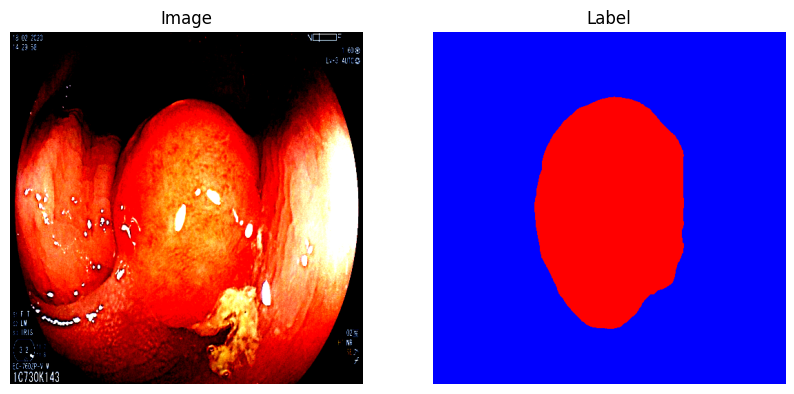

In [20]:
for images, labels in valid_dataloader: 
    images = images[0]
    labels = labels[0]
    # label_array = label.permute(1, 2, 0).cpu().numpy()
    image_array = images.permute(1, 2, 0).cpu().numpy()
    # Create a figure with 2 subplots (1 row, 2 columns)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    count = (labels.long() == 1).sum().item()
    print(count)
    
    axs[0].imshow(image_array)
    axs[0].set_title('Image')
    axs[0].axis('off')  
    
    axs[1].imshow(F.one_hot(labels).float())
    axs[1].set_title('Label')
    axs[1].axis('off')  
    plt.show()
    break

In [21]:

# fig, arr = plt.subplots(2, 2, figsize=(16, 12))
# for i, (data, label) in enumerate(train_dataloader):
#     img = data
#     mask = label
#     img = img.to(device)
#     gts = mask.to(device)
#     gts = gts.unsqueeze(1).float()
#     train_size = int(round(352*1.25/32)*32)
#     gts = nn.functional.interpolate(gts, size = (train_size, train_size), mode = 'bilinear', align_corners = True)
#     break
# a = gts.squeeze(1).long()

# x = torch.unique(mask[0].to(device).long())
# print(x)
# y = torch.unique(a[0].long())
# print(y)

# red_count = torch.sum(a[0] == 0).item() 
# green_count = torch.sum(a[0] == 1).item() 
# print(red_count)
# print(green_count)

# if red_count > green_count: 
#     a[0][a[0] == 1] = 0
# red_count = torch.sum(a[0] == 0).item() 
# green_count = torch.sum(a[0] == 1).item() 
# print(red_count)
# print(green_count)

# arr[0][0].imshow(F.one_hot(a[0]).cpu().float())
# arr[0][1].imshow(F.one_hot(mask[0]).cpu().float())
# arr[1][0].imshow(F.one_hot(a[1]).cpu().float())
# arr[1][1].imshow(F.one_hot(mask[1]).cpu().float())

# Loss function

In [22]:
class CEDiceLoss(nn.Module):
    def __init__(self, weights) -> None:
        super(CEDiceLoss, self).__init__()
        self.eps: float = 1e-6
        self.weights: torch.Tensor = weights

    def forward(
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:
        if not torch.is_tensor(input):
            raise TypeError("Input type is not a torch.Tensor. Got {}"
                            .format(type(input)))
        if not len(input.shape) == 4:
            raise ValueError("Invalid input shape, we expect BxNxHxW. Got: {}"
                             .format(input.shape))
        if not input.shape[-2:] == target.shape[-2:]:
            raise ValueError("input and target shapes must be the same. Got: {}"
                             .format(input.shape, input.shape))
        if not input.device == target.device:
            raise ValueError(
                "input and target must be in the same device. Got: {}" .format(
                    input.device, target.device))
        if not self.weights.shape[1] == input.shape[1]:
            raise ValueError("The number of weights must equal the number of classes")
        if not torch.sum(self.weights).item() == 1:
            raise ValueError("The sum of all weights must equal 1")
            
        # cross entropy loss
        celoss = nn.CrossEntropyLoss(self.weights)(input, target)
        
        # compute softmax over the classes axis
        input_soft = F.softmax(input, dim=1)

        # create the labels one hot tensor
        target_one_hot = one_hot(target, num_classes=input.shape[1],
                                 device=input.device, dtype=input.dtype)

        # compute the actual dice score
        dims = (2, 3)
        intersection = torch.sum(input_soft * target_one_hot, dims)
        cardinality = torch.sum(input_soft + target_one_hot, dims)

        dice_score = 2. * intersection / (cardinality + self.eps)
        
        dice_score = torch.sum(dice_score * self.weights, dim=1)
        
        return torch.mean(1. - dice_score) + celoss


# Training

**Initialize weights**

In [23]:
def weights_init(model):
    if isinstance(model, nn.Linear):
        # Xavier Distribution
        torch.nn.init.xavier_uniform_(model.weight)

In [24]:
checkpoint_path = '/kaggle/working/emcad_model.pth'
def save_model(model, path):
    torch.save(model.state_dict(), path)


**Train model**

In [25]:
supervision = 'mutation' 
i = 0
epoch = 0
outputs = torch.randn(4,8,3,352, 352)
if epoch == 0 and i == 0:
    n_outs = len(outputs)
    out_idxs = list(np.arange(n_outs)) #[0, 1, 2, 3]#, 4, 5, 6, 7]
    if supervision == 'mutation':
        ss = [x for x in powerset(out_idxs)]
    elif supervision == 'deep_supervision':
        ss = [[x] for x in out_idxs]
    else:
        ss = [[-1]]
    print(ss)

for s in ss:
    iout = 0.0
    if(s==[]):
        continue
    for idx in range(len(s)):
        iout += outputs[s[idx]]
    # print(iout.shape)

[[0, 1, 2, 3], [1, 2, 3], [0, 2, 3], [2, 3], [0, 1, 3], [1, 3], [0, 3], [3], [0, 1, 2], [1, 2], [0, 2], [2], [0, 1], [1], [0], []]


In [26]:
# Train function for each epoch
def train(train_dataloader, valid_dataloader,learing_rate_scheduler, epoch, display_step, ss):
    print(f"Start epoch #{epoch+1}, learning rate for this epoch: {learing_rate_scheduler.get_last_lr()}")
    start_time = time.time()
    train_loss_epoch = 0
    test_loss_epoch = 0
    last_loss = 99
    model.train()
    for i, (data,targets) in enumerate(train_dataloader):
        
        # Load data into GPU
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        
        loss = 0.0
        for s in ss:
            iout = 0.0
            if(s==[]):
                continue
            for idx in range(len(s)):
                iout += outputs[s[idx]]
            loss_temp = loss_function(iout, targets.long())
            loss += loss_temp

        # Backpropagation, compute gradients
        loss = loss/15
        loss.backward()

        # Apply gradients
        optimizer.step()
        
        # Save loss
        train_loss_epoch += loss.item()
        if (i+1) % display_step == 0:
            print('Train Epoch: {} [{}/{} ({}%)]\tLoss: {:.4f}'.format(
                epoch + 1, (i+1) * len(data), len(train_dataloader.dataset), 100 * (i+1) * len(data) / len(train_dataloader.dataset), 
                loss.item()))
                  
    print(f"Done epoch #{epoch+1}, time for this epoch: {time.time()-start_time}s")
    train_loss_epoch/= (i + 1)
    
    # Evaluate the validation set
    model.eval()
    with torch.no_grad():
        for i, (data, target) in enumerate(valid_dataloader):
            data, target = data.to(device), target.to(device)
            test_output = model(data)
            for s in ss:
                iout = 0.0
                if(s==[]):
                    continue
                for idx in range(len(s)):
                    iout += outputs[s[idx]]
                loss_temp = loss_function(iout, targets.long())
                loss += loss_temp
            test_loss_epoch += loss/15
        test_loss_epoch /= len(valid_dataloader)
            
    return train_loss_epoch , test_loss_epoch

In [27]:
# checkpoint = torch.load(pretrained_path, weights_only = True)
# model.load_state_dict(checkpoint)
# # model = nn.DataParallel(model)
# model.to(device)
try:
    checkpoint = torch.load(pretrained_path, weights_only = True)
    new_state_dict = OrderedDict() 
    for k, v in checkpoint.items(): 
        name = k[7:] 
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    model = nn.DataParallel(model)
    model.to(device)
    print('success')
except: 
    model = nn.DataParallel(model)
    model.to(device)
    print('failed')

success


In [28]:
weights = torch.Tensor([[0.34, 0.33, 0.33]]).cuda()
loss_function = CEDiceLoss(weights)

# Define the optimizer (Adam optimizer)
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

# Learning rate scheduler
learing_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.6)
# model  = nn.DataParallel(model)
model = model.to(device)


In [29]:
import numpy as np 
iout_idxs = list(np.arange(4)) 
ss = [x for x in powerset(iout_idxs)]

In [ ]:

wandb.login(key = '')
wandb.init(project = 'polypsegmentation', 
          name = 'EMCAD_pvt_b2')
# Training loop
last_loss = 99
for epoch in range(epochs):
    train_loss_epoch = 0
    test_loss_epoch = 0
    (train_loss_epoch, test_loss_epoch) = train(train_dataloader, 
                                              valid_dataloader, 
                                              learing_rate_scheduler, epoch, display_step,ss)
    
    if test_loss_epoch < last_loss:
        save_model(model, checkpoint_path)
        last_loss = test_loss_epoch
        
    learing_rate_scheduler.step()
    wandb.log({"Train loss": train_loss_epoch, "Valid loss": test_loss_epoch})


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hung123ka5. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241210_134016-zg3h39vk
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run EMCAD_pvt_b2
wandb: ⭐️ View project at https://wandb.ai/hung123ka5/polypsegmentation
wandb: 🚀 View run at https://wandb.ai/hung123ka5/polypsegmentation/runs/zg3h39vk


Start epoch #1, learning rate for this epoch: [5e-06]


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Train Epoch: 1 [400/1800 (22.22222222222222%)]	Loss: 0.4085
Train Epoch: 1 [800/1800 (44.44444444444444%)]	Loss: 0.3197
Train Epoch: 1 [1200/1800 (66.66666666666667%)]	Loss: 0.3190
Train Epoch: 1 [1600/1800 (88.88888888888889%)]	Loss: 0.3808
Done epoch #1, time for this epoch: 427.44973731040955s
Start epoch #2, learning rate for this epoch: [5e-06]
Train Epoch: 2 [400/1800 (22.22222222222222%)]	Loss: 0.3613
Train Epoch: 2 [800/1800 (44.44444444444444%)]	Loss: 0.3539
Train Epoch: 2 [1200/1800 (66.66666666666667%)]	Loss: 0.3574
Train Epoch: 2 [1600/1800 (88.88888888888889%)]	Loss: 0.3636
Done epoch #2, time for this epoch: 409.1361963748932s
Start epoch #3, learning rate for this epoch: [5e-06]
Train Epoch: 3 [400/1800 (22.22222222222222%)]	Loss: 0.3760
Train Epoch: 3 [800/1800 (44.44444444444444%)]	Loss: 0.3514
Train Epoch: 3 [1200/1800 (66.66666666666667%)]	Loss: 0.3283
Train Epoch: 3 [1600/1800 (88.88888888888889%)]	Loss: 0.3525
Done epoch #3, time for this epoch: 411.60126304626465s

# Visualization

In [31]:
x = torch.rand(8,3,512, 512).to(device)
y = model(x) 
y[0].shape

torch.Size([8, 3, 512, 512])

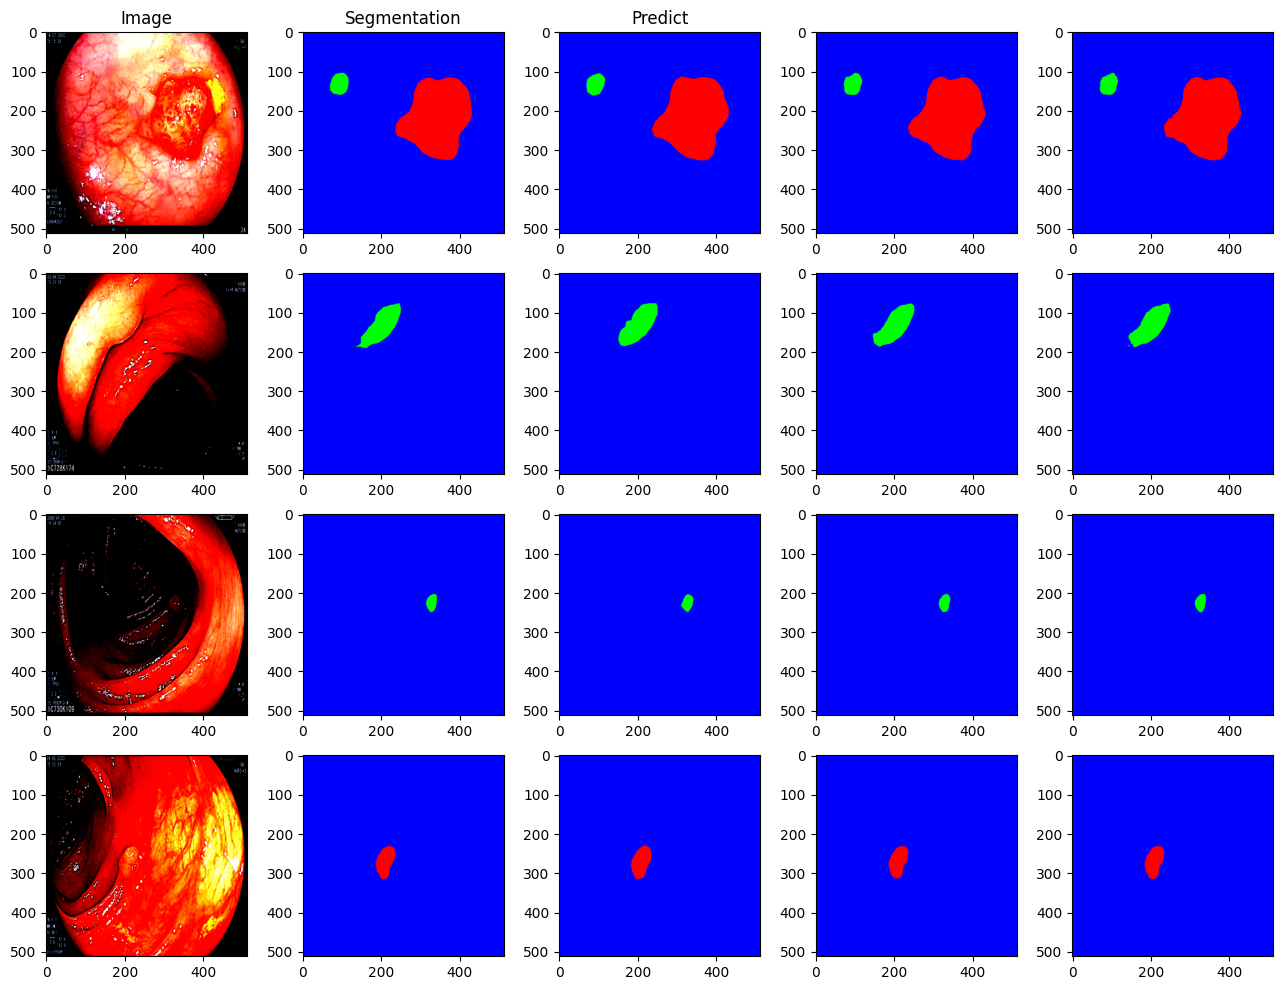

In [32]:
fig, arr = plt.subplots(4, 5, figsize=(16, 12))
arr[0][0].set_title('Image')
arr[0][1].set_title('Segmentation')
arr[0][2].set_title('Predict')
model.eval()
for i, (data, label) in enumerate(valid_dataloader):
    img = data
    mask = label
    img2 = img.to(device)
    with torch.no_grad():
        predict = model(img2)
        res3 = predict[3]
        res2 = predict[2]
        res1 = predict[1]
    if i == 0: break

for i in range(4):
    arr[i][0].imshow(img[i].permute(1, 2, 0));
    
    arr[i][1].imshow(F.one_hot(mask[i]).float())
    
    arr[i][2].imshow(F.one_hot(torch.argmax(res1[i], 0).cpu()).float())
    arr[i][3].imshow(F.one_hot(torch.argmax(res2[i], 0).cpu()).float())
    arr[i][4].imshow(F.one_hot(torch.argmax(res3[i], 0).cpu()).float())

In [33]:
class UNetTestDataClass(Dataset):
    def __init__(self, images_path, transform):
        super(UNetTestDataClass, self).__init__()
        
        images_list = os.listdir(images_path)
        images_list = [images_path+i for i in images_list]
        
        self.images_list = images_list
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.images_list[index]
        data = Image.open(img_path)
        h = data.size[1]
        w = data.size[0]
        data = self.transform(data)    
        return data, img_path, h, w
    
    def __len__(self):
        return len(self.images_list)

In [34]:
path = '/kaggle/input/bkai-igh-neopolyp/test/test/'
unet_test_dataset = UNetTestDataClass(path, transform)
test_dataloader = DataLoader(unet_test_dataset, batch_size=8, shuffle=False)

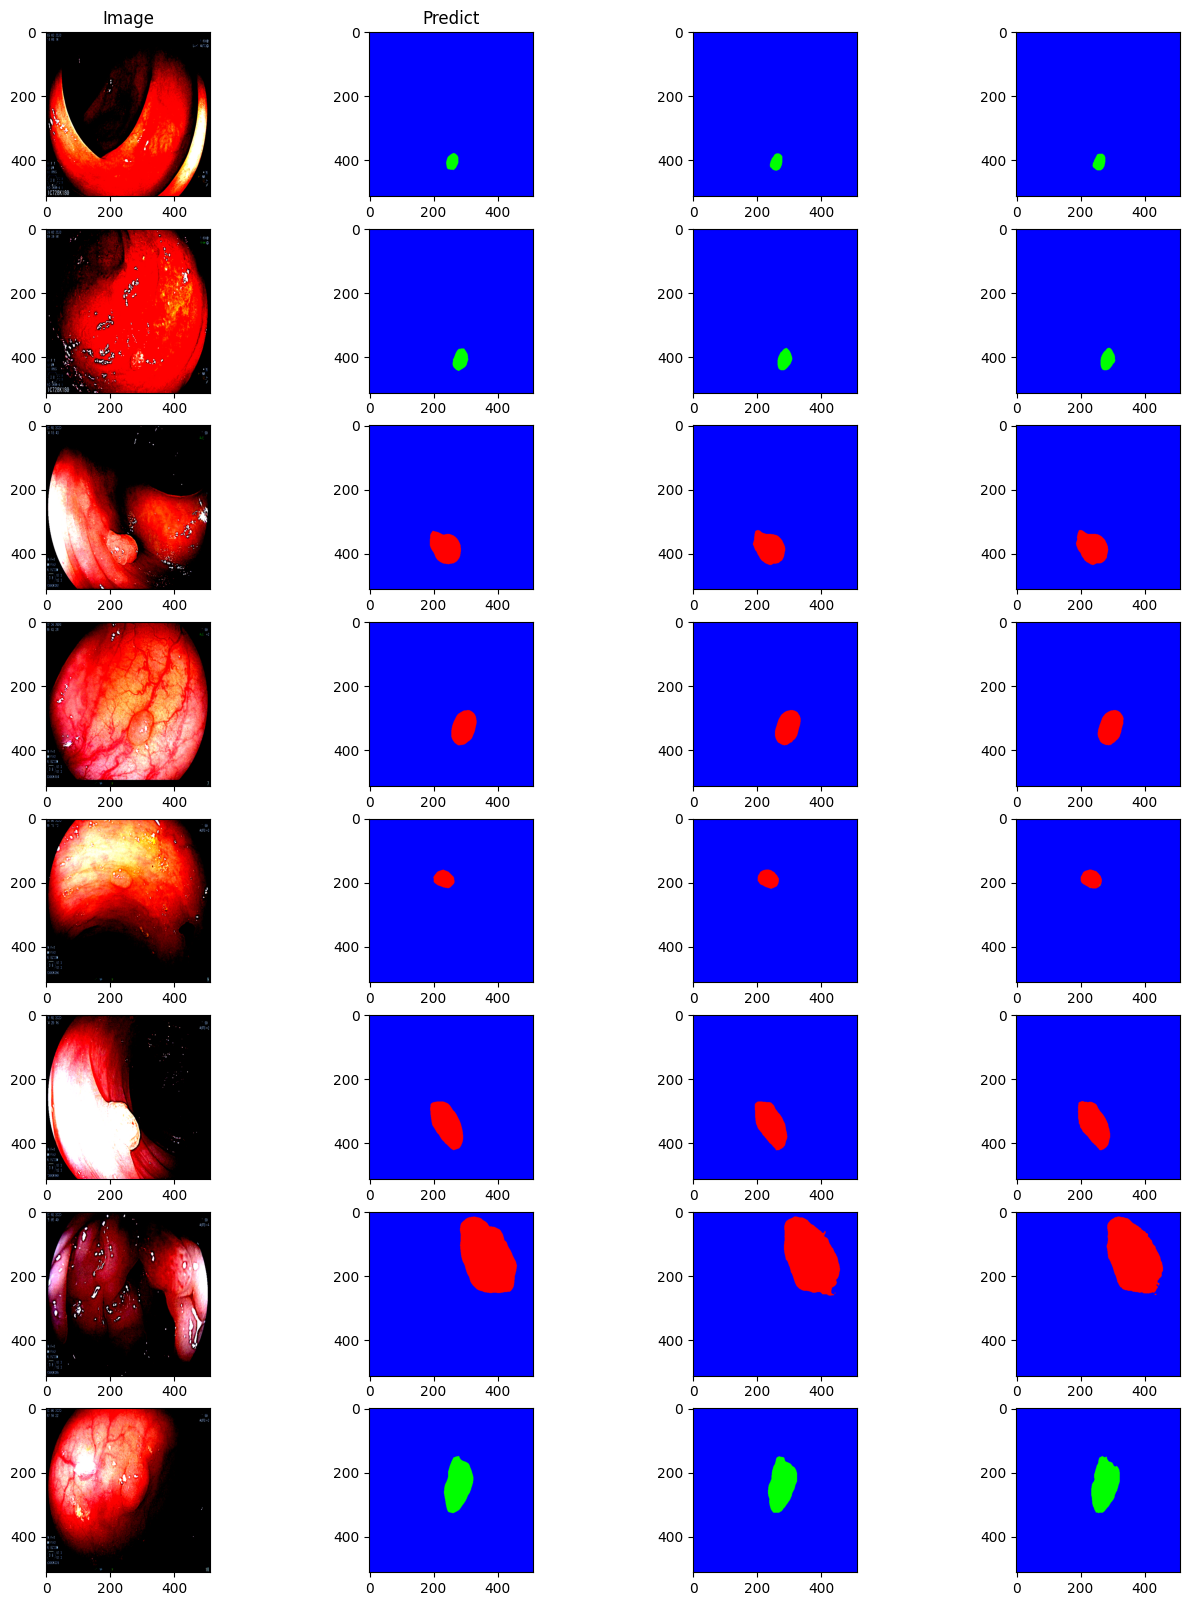

In [35]:
for i, (data, path, h, w) in enumerate(test_dataloader):
    img = data
    if i == 1: break
    
fig, arr = plt.subplots(8, 4, figsize=(16, 20))
arr[0][0].set_title('Image');
arr[0][1].set_title('Predict');
img2 = img.to(device)
model.eval()
with torch.no_grad():
    predict = model(img2)
    predict1 = predict[1]
    predict2 = predict[2]
    predict3 = predict[3]


for i in range(8):
    arr[i][0].imshow(img[i].permute(1, 2, 0));
    arr[i][1].imshow(F.one_hot(torch.argmax(predict1[i], 0).cpu()).float())
    arr[i][2].imshow(F.one_hot(torch.argmax(predict2[i], 0).cpu()).float())
    arr[i][3].imshow(F.one_hot(torch.argmax(predict3[i], 0).cpu()).float())


# x = torch.argmax(predict[2], 0)
# y = torch.unique(x)
# y

## Process after (1 color - 1 block)

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

def process_regions(image):
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Create mask for blue background
    lower_blue = np.array([100, 50, 50])
    upper_blue = np.array([140, 255, 255])
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)
    
    # Create masks for red and green
    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 50, 50])
    upper_red2 = np.array([180, 255, 255])
    red_mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    red_mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)
    
    lower_green = np.array([40, 50, 50])
    upper_green = np.array([80, 255, 255])
    green_mask = cv2.inRange(hsv, lower_green, upper_green)
    
    # Get non-blue regions
    non_blue_mask = cv2.bitwise_not(blue_mask)
    
    # Label connected components in non-blue regions
    labels, num_labels = ndimage.label(non_blue_mask)
    
    # Create result image
    result = np.zeros_like(image)
    result[blue_mask > 0] = [255, 0, 0]  # Set blue background
    
    # Process each labeled region
    for label in range(1, num_labels + 1):
        region_mask = (labels == label)
        
        # Count red and green pixels in this region
        red_count = cv2.countNonZero(cv2.bitwise_and(red_mask, region_mask.astype(np.uint8)))
        green_count = cv2.countNonZero(cv2.bitwise_and(green_mask, region_mask.astype(np.uint8)))
        
        # If only one color is present, use that color
        if red_count > 0 and green_count == 0:
            result[region_mask] = [0, 0, 255]  # Pure red
        elif green_count > 0 and red_count == 0:
            result[region_mask] = [0, 255, 0]  # Pure green
        # If mixed colors, use the dominant one
        else:
            if red_count > green_count:
                result[region_mask] = [0, 0, 255]  # Red
            else:
                result[region_mask] = [0, 255, 0]  # Green
    
    return result

In [37]:
model.eval()
if not os.path.isdir("/kaggle/working/predicted_masks"):
    os.mkdir("/kaggle/working/predicted_masks")
for _, (img, path, H, W) in enumerate(test_dataloader):
    a = path
    b = img.to(device)
    h = H
    w = W
    
    with torch.no_grad():
        predicted_mask = model(b)
        predicted_mask = predicted_mask[3]
    for i in range(len(a)):
        image_id = a[i].split('/')[-1].split('.')[0]
        filename = image_id + ".png"
        mask2img = Resize((h[i].item(), w[i].item()), interpolation=InterpolationMode.NEAREST)(ToPILImage()(F.one_hot(torch.argmax(predicted_mask[i], 0)).permute(2, 0, 1).float()))
        mask2img.save(os.path.join("/kaggle/working/predicted_masks/", filename))

In [38]:
processed_dir = '/kaggle/working/processed_masks_after'
# os.mkdir("/kaggle/working/processed_masks_after")

result_path = '/kaggle/working/predicted_masks'
results = os.listdir(result_path)
for i in range (len(results)): 
    img_path = os.path.join(result_path, results[i])
    processed_path = os.path.join(processed_dir, results[i])
    image = cv2.imread(img_path) 
    image = process_regions(image) 
    cv2.imwrite(processed_path, image)


In [39]:
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 0] = 255
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/processed_masks_after' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']
df.to_csv(r'output.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/processed_masks_after'

In [ ]:
pretrained_path = '/kaggle/working/emcad_model.pth'
path = torch.load(pretrained_path, weights_only = True)
model.load_state_dict(path)

model.eval()
if not os.path.isdir("/kaggle/working/predicted_masks2"):
    os.mkdir("/kaggle/working/predicted_masks2")
for _, (img, path, H, W) in enumerate(test_dataloader):
    a = path
    b = img.to(device)
    h = H
    w = W
    
    with torch.no_grad():
        predicted_mask = model(b)
        predicted_mask = predicted_mask[2]
    for i in range(len(a)):
        image_id = a[i].split('/')[-1].split('.')[0]
        filename = image_id + ".png"
        mask2img = Resize((h[i].item(), w[i].item()), interpolation=InterpolationMode.NEAREST)(ToPILImage()(F.one_hot(torch.argmax(predicted_mask[i], 0)).permute(2, 0, 1).float()))
        mask2img.save(os.path.join("/kaggle/working/predicted_masks2/", filename))

In [ ]:
processed_dir = '/kaggle/working/processed_masks_after2'
os.mkdir("/kaggle/working/processed_masks_after2")

result_path = '/kaggle/working/predicted_masks2'
results = os.listdir(result_path)
for i in range (len(results)): 
    img_path = os.path.join(result_path, results[i])
    processed_path = os.path.join(processed_dir, results[i])
    image = cv2.imread(img_path) 
    image = process_regions(image) 
    cv2.imwrite(processed_path, image)


In [ ]:
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 0] = 255
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/processed_masks_after2' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']
df.to_csv(r'output2.csv', index=False)